# Transformer Network

In [3]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification

## 1 - Positional Encoding

In [7]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos / 10000**(2*i/d)
    
    return angles

In [8]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.array([[x] for x in range(positions)]),
                            np.array([x for x in range(d)]),
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


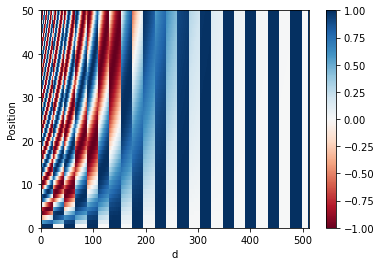

In [18]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 2 - Masking

In [9]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, :] 

In [10]:
def create_look_ahead_mask(sequence_length):
    """
    Returns an lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

## 3 - Self-Attention
self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

In [11]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    
    matmul_qk = tf.matmul(q, k.T)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += ((1. - mask)  * -1.0e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4 - Encoder

In [12]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

In [13]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        
        # calculate self-attention
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        attn_output = self.mha(x,x,x,mask) # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output during training
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer
        encoder_layer_out = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, fully_connected_dim)
        
        return encoder_layer_out
    

In [14]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        #mask = create_padding_mask(x)
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, fully_connected_dim)

## 5 - Decoder

In [15]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)
        
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input
        Q1 = self.layernorm1(mult_attn_out1 + x)

        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)  # (batch_size, target_seq_len, fully_connected_dim)
                
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)
        
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output + mult_attn_out2)  # (batch_size, target_seq_len, fully_connected_dim)

        return out3, attn_weights_block1, attn_weights_block2
    

In [16]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, fully_connected_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

## 6 - Transformer

In [17]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

<font color='blue'>
    <b>What you should remember</b>:

- The combination of self-attention and convolutional network layers allows of parallization of training and *faster training*.
- Self-attention is calculated using the generated query Q, key K, and value V matrices.
- Adding positional encoding to word embeddings is an effective way of include sequence information in self-attention calculations. 
- Multi-head attention can help detect multiple features in your sentence.
- Masking stops the model from 'looking ahead' during training, or weighting zeroes too much when processing cropped sentences. 